In [ ]:
#!pip install scikit-image

# 0. Loading Dataset

You can download the dataset from {https://darwin.v7labs.com/v7-labs/covid-19-chest-x-ray-dataset?sort=priority\%3Adesc}.
The data entitled as '`darwin dataset pull v7-labs/covid-19-chest-x-ray-dataset:all-images`' will be used in this assignment. All dataset consist of 6504 images from 702 classes. We will extract the images of 4 classes (Bacterial Pneumonia, Viral Pneumonia, No Pneumonia (healthy), Covid-19) and save them as .npy file with the following code:

In [ ]:
# Imports
import warnings
warnings.simplefilter(action='ignore')
import keras
import json
import numpy as np
import glob
import pandas as pd

import urllib.request
from PIL import Image
from keras import layers, models
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from skimage import io, color
import random



In [ ]:
###################################
# > DISABLED - ALREADY EXECUTED < #
###################################


# # all-images file should be uploaded to the same file
# imageNames = glob.glob("all-images/*")
# 
# dataset = []
# labels = []
# 
# for i, imName in enumerate(imageNames):
# 
#     # Opening JSON file
#     f = open(imName)
#     data = json.load(f)
#     for j in range(len(data['annotations'])):
# 
#         if 'COVID-19' in (data['annotations'][j]['name']):
#           #load images from url    
#             urllib.request.urlretrieve(data['image']['url'],"img.png")    
#             img = Image.open("img.png")
#             #convert images to grayscale
#             imgGray = img.convert('L')
#             #resize the image (156x156)
#             im = imgGray.resize((156,156), Image.LANCZOS)           
#             label = data['annotations'][j]['name']
#             dataset.append(np.array(im))
#             labels.append(label)
#             print(label)
#             break
# 
#         if 'Viral Pneumonia' in (data['annotations'][j]['name']) \
#             or 'Bacterial Pneumonia' in (data['annotations'][j]['name']) \
#             or 'No Pneumonia (healthy)' in (data['annotations'][j]['name']):
#             #load images from url    
#             urllib.request.urlretrieve(data['image']['url'],"img.png")    
#             img = Image.open("img.png")
#             #convert images to grayscale
#             imgGray = img.convert('L')
#             #resize the image (156x156)
#             im = imgGray.resize((156,156), Image.LANCZOS)           
#             label = data['annotations'][j]['name']
#             dataset.append(np.array(im))
#             labels.append(label)
#             break
# 
# #Convert data shape of (n_of_samples, width, height, 1)
# dataset = np.dstack(dataset)    
# dataset = np.rollaxis(dataset,-1)
# labels = np.array(labels)
# 
# #convert images gray scale to rgb
# data = np.array(layers.Lambda(tf.image.grayscale_to_rgb)(tf.expand_dims(dataset, -1)))
# 
# # save data and labels into a folder
# np.save("data.npy", data)
# np.save("labels.npy", labels)

Once you save your data, you can load it from your directory.

In [ ]:
features = np.load('/content/drive/MyDrive/newdata/data.npy')
labels = np.load('/content/drive/MyDrive/newdata/labels.npy')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Data preprocessing



### 1.1 Splitting Data

In [ ]:
'''
Note from Diego: discuss in the meeting 
what is exactly stratify and do we need it?
'''

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42, stratify=labels)

# Further split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)


In [ ]:
print(len(X_train))
print(len(X_val))
print(len(X_test))

4147
1383
1383


### Extra: Easy going here! - Sample restriction 😎🤙🌴  \#prayforkernel 🙏

In [ ]:
#############################################
#             CONTROL PANEL

# Sample restriction
restriction = True
proportion = 0.25
#                                           
#############################################

In [ ]:
def collect_labels(data, labels):
    
    img_label_dict = {}
    
    # relate image and label index in dictionary
    for i in range(len(labels)):
        img_label_dict[i] = labels[i]
        
        
    # Store all the indexes by label
    BP_index = {k for k,v in img_label_dict.items() if v == 'Bacterial Pneumonia'}
    VP_index = {k for k,v in img_label_dict.items() if v == 'Viral Pneumonia'}
    NP_index = {k for k,v in img_label_dict.items() if v == 'No Pneumonia (healthy)'}
    
    CV_index = {k for k,v in img_label_dict.items() if v == 'COVID-19'}

    return [BP_index, VP_index, NP_index, CV_index], img_label_dict


def restrict_sample(proportion, data, labels):

    classified_instances, img_label_dict = collect_labels(data, labels)

    restricted_sample_indices = set()
    restricted_img_label_dict = {}

    for i in classified_instances[:-1]:
        tmp = random.sample(i, k=int(len(i)*proportion))
        for e in tmp:
            restricted_sample_indices.add(e)

    restricted_sample_indices = restricted_sample_indices.union(classified_instances[-1])
    restricted_sample_labels = [img_label_dict.get(i) for i in restricted_sample_indices]
    restricted_sample = [data[i] for i in restricted_sample_indices]

    return restricted_sample, restricted_sample_labels

In [ ]:
if restriction == True:

    restricted_sample_train, restricted_sample_labels_train = restrict_sample(proportion , X_train, y_train)
    restricted_sample_val, restricted_sample_labels_val = restrict_sample(proportion , X_val, y_val)
    restricted_sample_test, restricted_sample_labels_test = restrict_sample(proportion , X_test, y_test)

In [ ]:
if restriction == True:
    
    ############################
    # > RESTRICTION  SUMMARY < #
    ############################
    print("SAMPLE RESTRICTION SUMMARY")
    print("")
    print("")
    print("ORIGINAL TRAINING SAMPLE")
    print(F"Original number of instances: {len(X_train)}")
    print(f"Original instance distribution by class: \n {pd.Series(y_train).value_counts()}")
    print("")
    print("RESTRICTED TRAINING SAMPLE")
    print(f"Number of instances in restricted sample: {len(restricted_sample_train)}")
    print(f"Instance distribution by class in restricted sample: \n {pd.Series(restricted_sample_labels_train).value_counts()}")
    
    X_train = np.array(restricted_sample_train)
    y_train = np.array(restricted_sample_labels_train)
    X_val = np.array(restricted_sample_val)
    y_val = np.array(restricted_sample_labels_val)
    X_test = np.array(restricted_sample_test)
    y_test = np.array(restricted_sample_labels_test)
    
else:
    print("SAMPLE RESTRICTION WAS NOT CONDUCTED")

SAMPLE RESTRICTION SUMMARY


ORIGINAL TRAINING SAMPLE
Original number of instances: 4147
Original instance distribution by class: 
 Bacterial Pneumonia       1689
Viral Pneumonia           1182
No Pneumonia (healthy)     963
COVID-19                   313
dtype: int64

RESTRICTED TRAINING SAMPLE
Number of instances in restricted sample: 1270
Instance distribution by class in restricted sample: 
 Bacterial Pneumonia       422
COVID-19                  313
Viral Pneumonia           295
No Pneumonia (healthy)    240
dtype: int64


In [ ]:
print(len(X_train))
print(len(X_val))
print(len(X_test))

1270
422
423


### 1.2 Normalize Data

In [ ]:
'''
Note from Diego:  discuss in the meeting 
shall we keep only one code snippet for normalize? Select whichever is the most appropriate
'''

#making them float 
X_train=X_train.astype('float32')
X_test=X_test.astype('float32')
X_val=X_val.astype('float32')

#Normalizing the data between 0 and 1 
X_train=X_train/255.0
X_test=X_test/255.0
X_val=X_val/255.0


# Compute the mean and standard deviation of the training set
train_mean = np.mean(X_train, axis=0)
train_std = np.std(X_train, axis=0)

# Normalize each set separately using the training set statistics
X_train_norm = (X_train - train_mean) / train_std
X_val_norm = (X_val - train_mean) / train_std
X_test_norm = (X_test - train_mean) / train_std


### 1.3 Categorical encoding

In [ ]:
# Define a dictionary that maps each category to a numerical value
label_map = {"Bacterial Pneumonia": 0, "Viral Pneumonia": 1, "No Pneumonia (healthy)": 2, "COVID-19": 3}

# Encode the categorical labels as numerical values using the label map
y_train_encoded = np.vectorize(label_map.get)(y_train)
y_val_encoded = np.vectorize(label_map.get)(y_val)
y_test_encoded = np.vectorize(label_map.get)(y_test)

# Convert the numerical labels to one-hot encoded format
num_classes = 4
y_train_onehot = keras.utils.to_categorical(y_train_encoded, num_classes=num_classes)
y_val_onehot = keras.utils.to_categorical(y_val_encoded, num_classes=num_classes)
y_test_onehot = keras.utils.to_categorical(y_test_encoded, num_classes=num_classes)



# 2. Baseline Model

### 2.1 Create baseline model

In [ ]:

from tensorflow import keras

def build_baseline_model():
    model = keras.Sequential([
        # Convolutional layers
        keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=(156, 156, 3)),
        keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        # Dense layers
        keras.layers.Flatten(),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(4, activation='softmax')
    ])

    # Compile the model with appropriate loss function, optimizer, and metrics
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model


baseline_model = build_baseline_model()

# Train the model for 10 epochs with a batch size of 32
history = baseline_model.fit(
    X_train_norm,
    y_train_onehot,
    batch_size=32,
    epochs=10,
    validation_data=(X_val_norm, y_val_onehot)
)


2023-03-04 09:02:23.053470: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-04 09:02:23.055078: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-04 09:02:23.056046: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (be39edd05863): /proc/driver/nvidia/version does not exist
2023-03-04 09:02:23.064725: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-04 09:02:23.682938: W tensorflow/tsl/framework/cpu_allocator_im

Epoch 1/10


2023-03-04 09:02:27.128376: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 194281472 exceeds 10% of free system memory.
2023-03-04 09:02:29.578815: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 194281472 exceeds 10% of free system memory.


 1/40 [..............................] - ETA: 4:38 - loss: 1.3875 - accuracy: 0.2500

2023-03-04 09:02:31.498282: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 194281472 exceeds 10% of free system memory.
2023-03-04 09:02:33.262060: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 194281472 exceeds 10% of free system memory.


40/40 [==============================] - 156s 4s/step - loss: 1.1333 - accuracy: 0.5354 - val_loss: 0.9355 - val_accuracy: 0.6280
Epoch 2/10
40/40 [==============================] - 147s 4s/step - loss: 0.8364 - accuracy: 0.6630 - val_loss: 0.9171 - val_accuracy: 0.6469
Epoch 3/10
40/40 [==============================] - 145s 4s/step - loss: 0.7316 - accuracy: 0.7126 - val_loss: 0.8077 - val_accuracy: 0.6801
Epoch 4/10
40/40 [==============================] - 142s 4s/step - loss: 0.6202 - accuracy: 0.7567 - val_loss: 0.8000 - val_accuracy: 0.6943
Epoch 5/10
40/40 [==============================] - 133s 3s/step - loss: 0.5285 - accuracy: 0.7882 - val_loss: 0.9739 - val_accuracy: 0.6706
Epoch 6/10
40/40 [==============================] - 132s 3s/step - loss: 0.5007 - accuracy: 0.7882 - val_loss: 0.7928 - val_accuracy: 0.6777
Epoch 7/10
40/40 [==============================] - 131s 3s/step - loss: 0.3847 - accuracy: 0.8409 - val_loss: 0.9787 - val_accuracy: 0.6872
Epoch 8/10
40/40 [======

### 2.2 Analyze the performance of the baseline model

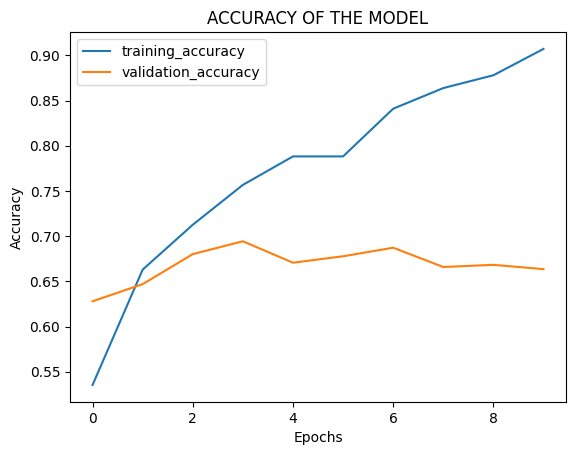

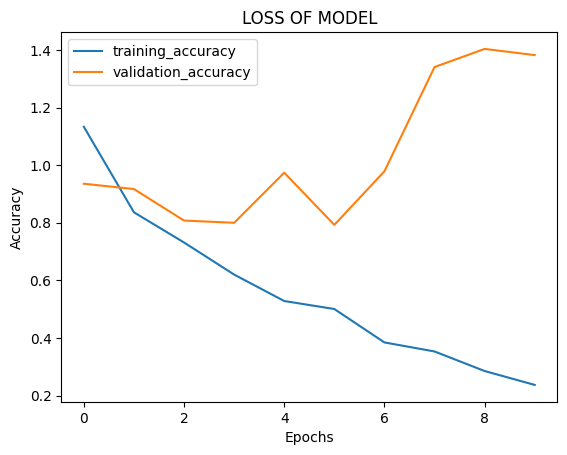

14/14 [==============================] - 8s 497ms/step


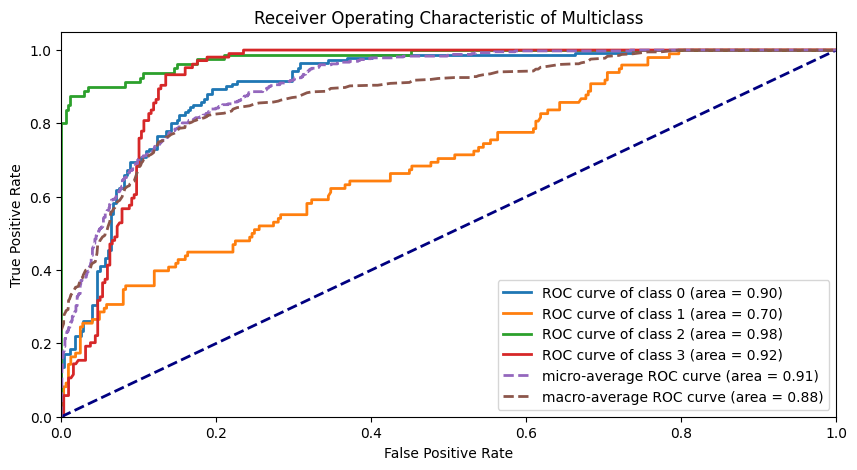

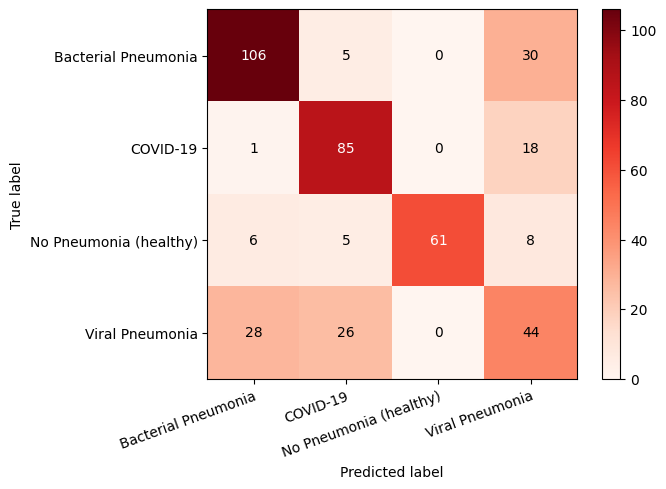

                        precision    recall  f1-score   support

   Bacterial Pneumonia       0.75      0.75      0.75       141
              COVID-19       0.70      0.82      0.76       104
No Pneumonia (healthy)       1.00      0.76      0.87        80
       Viral Pneumonia       0.44      0.45      0.44        98

              accuracy                           0.70       423
             macro avg       0.72      0.70      0.70       423
          weighted avg       0.71      0.70      0.70       423



In [ ]:
import matplotlib.pyplot as plt

##Plot for the accuracy of the baseline model 
accuracy_train = history.history['accuracy']
accuracy_val = history.history['val_accuracy']
plt.plot(accuracy_train, label='training_accuracy')
plt.plot(accuracy_val, label='validation_accuracy')
plt.title('ACCURACY OF THE MODEL')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

##Plot for the loss of the baseline model 
loss_train = history.history['loss']
loss_val = history.history['val_loss']
plt.plot(loss_train, label='training_accuracy')
plt.plot(loss_val, label='validation_accuracy')
plt.title('LOSS OF MODEL')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

##ROC curve 
y_pred = baseline_model.predict(X_test_norm) 

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
fpr = {}
tpr = {}
roc_auc = {}

#calculating roc for each class
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:,i], y_pred[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
from sklearn.metrics import roc_auc_score

# calculating micro-average ROC curve and  area
fpr_micro, tpr_micro, _ = roc_curve(y_test_onehot.ravel(), y_pred.ravel())
roc_auc_micro = roc_auc_score(y_test_onehot.ravel(), y_pred.ravel())

# Compute macro-average ROC curve and  area
fpr_macro = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
tpr_macro = np.zeros_like(fpr_macro)
for i in range(num_classes):
    tpr_macro += np.interp(fpr_macro, fpr[i], tpr[i])
tpr_macro /= num_classes
roc_auc_macro = auc(fpr_macro, tpr_macro)

#Plot the ROC curve for each class using matplotlib.pyplot.plot()
plt.figure(figsize=(10, 5))
lw = 2
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=lw, label='ROC curve of class %d (area = %0.2f)' % (i, roc_auc[i]))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.plot(fpr_micro, tpr_micro,lw=lw, linestyle='--', label='micro-average ROC curve (area = %0.2f)' % (roc_auc_micro))
plt.plot(fpr_macro, tpr_macro,lw=lw, linestyle='--', label='macro-average ROC curve (area = %0.2f)' % (roc_auc_macro))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic of Multiclass')
plt.legend(loc="lower right")
plt.show()

#reversing pred to categorical so to get the labels 
inverse_label_map = {v: k for k, v in label_map.items()}  # invert the label_map
y_pred_decoded_numerical = np.argmax(y_pred, axis=1)
y_pred_decoded_categorical = np.vectorize(inverse_label_map.get)(y_pred_decoded_numerical)

#confusion matrix 
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_decoded_categorical)
classes = np.unique(y_test)
# plot the confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap='Reds')
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=classes, yticklabels=classes, ylabel='True label', xlabel='Predicted label')

# rotate the labels
plt.setp(ax.get_xticklabels(), rotation=20, ha="right", rotation_mode="anchor")
# text annotations like the numbers inside 
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black")
plt.show()


#precision and recall and f1-score 
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_decoded_categorical))

# 3. Adapting/fine-tuning the network

In [ ]:
#############################################
#             CONTROL PANEL

# Sample restriction
restriction = True
proportion = 0.25

# Sample augmentation
augmentation_flip = False                       
augmentation_rotate = False

#                                           
#############################################


# safety mechanism: augmentation and restriction are not meant to be combined
if restriction == True:
    agumentation_flip = False
    augmentation_rotate = False

In [ ]:
# Defining some useful functions for restrition/augmentation

def collect_labels(data, labels):
    
    img_label_dict = {}
    
    # relate image and label index in dictionary
    for i in range(len(labels)):
        img_label_dict[i] = labels[i]
        
        
    # Store all the indexes by label
    BP_index = {k for k,v in img_label_dict.items() if v == 'Bacterial Pneumonia'}
    VP_index = {k for k,v in img_label_dict.items() if v == 'Viral Pneumonia'}
    NP_index = {k for k,v in img_label_dict.items() if v == 'No Pneumonia (healthy)'}
    
    CV_index = {k for k,v in img_label_dict.items() if v == 'COVID-19'}

    return [BP_index, VP_index, NP_index, CV_index], img_label_dict


def restrict_sample(proportion, data, labels):

    classified_instances, img_label_dict = collect_labels(X_train, y_train)

    restricted_sample_indices = set()
    restricted_img_label_dict = {}

    for i in classified_instances[:-1]:
        tmp = random.sample(i, k=int(len(i)*proportion))
        for e in tmp:
            restricted_sample_indices.add(e)

    restricted_sample_indices = restricted_sample_indices.union(classified_instances[-1])
    restricted_sample_labels = [img_label_dict.get(i) for i in restricted_sample_indices]
    restricted_sample = [data[i] for i in restricted_sample_indices]

    return restricted_sample, restricted_sample_labels
    
def rotate90(image):
    return tf.image.rot90(image)

def rotate180(image):
    return tf.image.rot90(rotate90(image))

def rotate270(image):
    return tf.image.rot90(rotate180(image))  


def augment_sample(features, labels):

    img_label_dict = {}
    
    # relate image and label index in dictionary
    for i in range(len(labels)):
        img_label_dict[i] = labels[i]
        
        
    # Store all the indexes by label
    BP_index = {k for k,v in img_label_dict.items() if v == 'Bacterial Pneumonia'}
    VP_index = {k for k,v in img_label_dict.items() if v == 'Viral Pneumonia'}
    NP_index = {k for k,v in img_label_dict.items() if v == 'No Pneumonia (healthy)'}
    
    CV_index = {k for k,v in img_label_dict.items() if v == 'COVID-19'}
    
    # Create list with all the previous lists so it can be used to iterate (except covid)
    labels_collect = [BP_index, VP_index, NP_index]
    
    # Select random sample of 50% of each element which is not covid to apply flip transformation
    # The remaining 50% stays the same
    to_transform = set()
    
    for i in labels_collect:
        tmp = random.sample(i, k=int(len(i)*0.5))
        for e in tmp:
            to_transform.add(e)
            
    not_to_transform = set(img_label_dict.keys()) - to_transform - CV_index
    # Creating list for keeping track of the labels for the new data        
    new_labels = []

    for i in to_transform:
        new_labels.append(img_label_dict.get(i))
    for i in not_to_transform:
        new_labels.append(img_label_dict.get(i))
    
    # Transform the sampled images and include these in the dataset while deleting the original ones
    new_features_no_cv = []
    
    for i in to_transform: # First all transformed instaces are added to the new list
            new_features_no_cv.append(tf.image.flip_left_right(features[i]))
    for i in not_to_transform: # And then those that will stay the same
            new_features_no_cv.append(features[i])
    
    # Include in new feature set covid x-rays + augmented covid x-rays
    new_features_cv = []
    
    for i in CV_index:
        new_features_cv.append(tf.image.flip_left_right(features[i]))
        new_features_cv.append(features[i])
    
    if augmentation_rotate == False:
        
        new_labels_cv = ['COVID-19' for i in range(len(new_features_cv))]
        
        augmentedfeatures = new_features_no_cv + new_features_cv
        augmentedlabels = new_labels + new_labels_cv
        
        return augmentedfeatures, augmentedlabels
        
    # AUGMENTATION - ROTATE    
    elif augmentation_rotate == True:
        
        #Divide no_cv instances in 3 groups (30%, 35%, 35%)
        
        fd_features, features_1, fd_labels, labels_1 = train_test_split(new_features_no_cv, new_labels, 
                                                            test_size=0.3, random_state=42)
        
        features_2, features_3, labels_2, labels_3 = train_test_split(fd_features, fd_labels, 
                                                            test_size=0.5, random_state=42)
        
        # Apply rotate90 to the first group and add both original and rotated to the new feature set alongside the labels
        
        new_features_2 = []
        new_labels_2 = []
        
        for i in range(len(features_1)):
            new_features_2.append(features_1[i])
            new_features_2.append(rotate90(features_1[i]))
            for e in range(2):
                new_labels_2.append(labels_1[i])
        
        # Idem 180
        
        for i in range(len(features_2)):
            new_features_2.append(features_2[i])
            new_features_2.append(rotate180(features_2[i]))
            for e in range(2):
                new_labels_2.append(labels_2[i])
        
        # Idem 270
        
        for i in range(len(features_3)):
            new_features_2.append(features_3[i])
            new_features_2.append(rotate270(features_3[i]))
            for e in range(2):
                new_labels_2.append(labels_3[i])
        
        #Apply all rotations to all cv features and add them to the new set alongside the originals and the labels
        
        for i in range(len(new_features_cv)):
            new_features_2.append(new_features_cv[i])
            new_features_2.append(rotate90(features_3[i]))
            new_features_2.append(rotate180(features_3[i]))
            new_features_2.append(rotate270(features_3[i]))
            for e in range(4):
                new_labels_2.append('COVID-19')
        
        
        augmentedfeatures = new_features_2
        augmentedlabels = new_labels_2
        
        return augmentedfeatures, augmentedlabels

### [DISABLED] 3.1 Data restriction 

In [ ]:
#if restriction == True:
#
#    restricted_sample, restricted_sample_labels = restrict_sample(proportion , X_train, y_train)

In [ ]:
#if restriction == True:
#    
#    ############################
#    # > RESTRICTION  SUMMARY < #
#    ############################
#    print("SAMPLE RESTRICTION SUMMARY")
#    print("")
#    print("")
#    print("ORIGINAL SAMPLE")
#    print(F"Original number of instances: {len(X_train)}")
#    print(f"Original instance distribution by class: \n {pd.Series(y_train).value_counts()}")
#    print("")
#    print("RESTRICTED SAMPLE")
#    print(f"Number of instances in restricted sample: {len(restricted_sample)}")
#    print(f"Instance distribution by class in restricted sample: \n {pd.Series(restricted_sample_labels).value_counts()}")
#    
#    X_train = np.array(restricted_sample)
#    y_train = np.array(restricted_sample_labels)
#    
#else:
#    print("SAMPLE RESTRICTION WAS NOT CONDUCTED")

SAMPLE RESTRICTION SUMMARY


ORIGINAL SAMPLE
Original number of instances: 4147
Original instance distribution by class: 
 Bacterial Pneumonia       1689
Viral Pneumonia           1182
No Pneumonia (healthy)     963
COVID-19                   313
dtype: int64

RESTRICTED SAMPLE
Number of instances in restricted sample: 957
Instance distribution by class in restricted sample: 
 Bacterial Pneumonia       422
COVID-19                  313
Viral Pneumonia           295
No Pneumonia (healthy)    240
dtype: int64


### 3.2 [DISABLED] Data Augmentation

In [ ]:
#if augmentation_flip == True:
#
#    augmentedfeatures, augmentedlabels_ = augment_sample(X_train, y_train)

In [ ]:
#if augmentation_flip == True:
#    
#    ############################
#    # > AUGMENTATION SUMMARY < #
#    ############################
#    
#    print("SAMPLE AUGMENTATION SUMMARY")
#    print("")
#    print("")
#    print("ORIGINAL SAMPLE")
#    print(F"Original number of instances: {len(labels)}")
#    print(f"Original instance distribution by class: \n {pd.Series(labels).value_counts()}")
#    print("")
#    print("AUGMENTED SAMPLE")
#    print(f"Number of instances in augmented sample: {len(augmentedlabels)}")
#    print(f"Instance distribution by class in augmented sample: \n {pd.Series(augmentedlabels).value_counts()}")
#    
#    X_train = np.array(augmentedfeatures)
#    y_train = np.array(augmentedlabels)
#
#else:
#    print("SAMPLE AUGMENTATION WAS NOT CONDUCTED")

SAMPLE AUGMENTATION WAS NOT CONDUCTED


### 3.3 [DISABLED] Categorical encoding of new labels

In [ ]:
## Define a dictionary that maps each category to a numerical value
#label_map = {"Bacterial Pneumonia": 0, "Viral Pneumonia": 1, "No Pneumonia (healthy)": 2, "COVID-19": 3}
#
## Encode the categorical labels as numerical values using the label map
#y_train_encoded = np.vectorize(label_map.get)(y_train)
#y_val_encoded = np.vectorize(label_map.get)(y_val)
#y_test_encoded = np.vectorize(label_map.get)(y_test)
#
## Convert the numerical labels to one-hot encoded format
#num_classes = 4
#y_train_onehot = keras.utils.to_categorical(y_train_encoded, num_classes=num_classes)
#y_val_onehot = keras.utils.to_categorical(y_val_encoded, num_classes=num_classes)
#y_test_onehot = keras.utils.to_categorical(y_test_encoded, num_classes=num_classes)

### 3.4 Network fine tuning

In [ ]:
# First, let's find an optimum learning rate for the baseline model:
# We will set less epochs to make it faster (epochs = 6)

from tensorflow import keras
import keras.backend as K
import matplotlib.pyplot as plt

def lr_schedule(epoch, initial_lr, final_lr, total_epochs):
    """
    calculates the learning rate for each epoch based on the initial learning rate, final learning rate, and total number of epochs
    """
    lr = initial_lr + (final_lr - initial_lr) * (epoch / float(total_epochs))
    return lr

def plot_lr_schedule(initial_lr, final_lr, total_epochs):
    lr = [lr_schedule(epoch, initial_lr, final_lr, total_epochs) for epoch in range(total_epochs)]
    plt.plot(lr, history.history['val_loss'])
    plt.xlabel('Learning Rate')
    plt.ylabel('Validation Loss')
    plt.title('Learning Rate Schedule')
    plt.show()

# Adding a Lr Scheduler to check the learning rate evolution during training and to avoid overfitting
initial_lr = 0.002
final_lr = 0.01
baseline_epochs = 6

lr_scheduler = keras.callbacks.LearningRateScheduler(lambda epoch: lr_schedule(epoch, initial_lr, final_lr, baseline_epochs))

# Train the model for 4 epochs with a batch size of 32
history = baseline_model.fit(
    X_train_norm,
    y_train_onehot,
    batch_size=32,
    epochs=6,
    validation_data=(X_val_norm, y_val_onehot),
    callbacks=[lr_scheduler]
)


In [ ]:
# Rule of thumb: optimal will be a bit lower than when lr starts climbing, usually 10 times lower the climb up point (around 0.005)
plot_lr_schedule(initial_lr, final_lr, baseline_epochs)

In [ ]:
"""from keras import backend as K

# Some memory clean-up
K.clear_session()"""

In [ ]:
# TUNED MODEL 1: BASELINE + LR SCHEDULER + KFOLD VALIDATION + EARLY STOPPING
from tensorflow import keras
from sklearn.model_selection import GridSearchCV
'alpha1': 0.01, 'alpha2': 0.1, 'alpha3': 0.01, 'alpha4': 0.1, 'alpha5': 0.1
def build_optimized_model(alpha1,alpha2,alpha3,alpha4,alpha5):
    model = keras.Sequential([
        # Convolutional layers
        keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation=keras.layers.LeakyReLU(alpha=0.01), input_shape=(156, 156, 3)),
        keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation=keras.layers.LeakyReLU(alpha=0.01)),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation=keras.layers.LeakyReLU(alpha=0.1)),
        keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation=keras.layers.LeakyReLU(alpha=0.1)),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(filters=64, kernel_size=(3, 3),activation=keras.layers.LeakyReLU(alpha=0.01)),
        keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation=keras.layers.LeakyReLU(alpha=0.01)),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        # Dense layers
        keras.layers.Flatten(),
        keras.layers.Dense(32, activation=keras.layers.LeakyReLU(alpha=0.1)),
        keras.layers.Dense(32,activation=keras.layers.LeakyReLU(alpha=0.1)),
        keras.layers.Dense(4,activation='softmax')
    ])

    # Compile the model with appropriate loss function, optimizer, and metrics
    optim = keras.optimizers.Nadam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

    return model




# Train the model for 10 epochs with a batch size of 32
# Define the hyperparameters to test
param_grid = {
    'alpha1': [0.1, 0.01],
    'alpha2': [0.1, 0.01],
    'alpha3': [0.1, 0.01],
    'alpha4': [0.1, 0.01],
    'alpha5': [0.1, 0.01]
}

# Create a KerasClassifier with the create_model function
model = keras.wrappers.scikit_learn.KerasClassifier(build_fn=build_optimized_model, epochs=1, batch_size=32)

# Perform a grid search to find the best hyperparameters
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train_norm, y_train_onehot)

# Print the results of the grid search
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

40/40 [==============================] - 9s 96ms/step - loss: 0.9847 - accuracy: 0.5835
Best: 0.703172 using {'alpha1': 0.01, 'alpha2': 0.1, 'alpha3': 0.01, 'alpha4': 0.1, 'alpha5': 0.1}


In [ ]:

import optuna
import tensorflow as tf
from tensorflow import keras

def create_model(trial):
    model = keras.Sequential([
        # Convolutional layers
        keras.layers.Conv2D(
            filters=trial.suggest_categorical('filters_1', [32, 64, 128]),
            kernel_size=trial.suggest_categorical('kernel_size_1', [(3, 3), (5, 5)]),
            activation='relu',
            input_shape=(156, 156, 3)
        ),
        keras.layers.Conv2D(
            filters=trial.suggest_categorical('filters_2', [32, 64, 128]),
            kernel_size=trial.suggest_categorical('kernel_size_2', [(3, 3), (5, 5)]),
            activation='relu'
        ),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(
            filters=trial.suggest_categorical('filters_3', [32, 64, 128]),
            kernel_size=trial.suggest_categorical('kernel_size_3', [(3, 3), (5, 5)]),
            activation='relu'
        ),
        keras.layers.Conv2D(
            filters=trial.suggest_categorical('filters_4', [32, 64, 128]),
            kernel_size=trial.suggest_categorical('kernel_size_4', [(3, 3), (5, 5)]),
            activation='relu'
        ),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(
            filters=trial.suggest_categorical('filters_5', [32, 64, 128]),
            kernel_size=trial.suggest_categorical('kernel_size_5', [(3, 3), (5, 5)]),
            activation='relu'
        ),
        keras.layers.Conv2D(
            filters=trial.suggest_categorical('filters_6', [32, 64, 128]),
            kernel_size=trial.suggest_categorical('kernel_size_6', [(3, 3), (5, 5)]),
            activation='relu'
        ),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        # Dense layers
        keras.layers.Flatten(),
        keras.layers.Dense(units=trial.suggest_int('units_1', 16, 128), activation='relu'),
        keras.layers.Dense(units=trial.suggest_int('units_2', 16, 128), activation='relu'),
        keras.layers.Dense(units=4, activation='softmax')
    ])

    # Compile the model with appropriate loss function, optimizer, and metrics
    model.compile(
        loss='categorical_crossentropy',
        optimizer=keras.optimizers.Adam(
            learning_rate=trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
        ),
        metrics=['accuracy']
    )
    
    return model

def objective(trial):
    # Create the model with the hyperparameters suggested by Optuna
    model = create_model(trial)
    
    # Train the model for 5 epochs
    history = model.fit(
        X_train_norm,
        y_train_onehot,
        batch_size=32,
        epochs=5,
        validation_data=(X_val_norm, y_val_onehot),
        verbose=0
    )
    
    # Evaluate the model
    loss = history.history['val_loss'][-1]
    return loss

# Define the study
study = optuna.create_study(direction='minimize')

# Start the optimization process
study.optimize(objective, n_trials=100)

# Print the best hyperparameters found by Optuna
print(f'Best hyperparameters: {study.best_params}')

# Create the best model
best_model = create_model(study.best_trial)

# Train the best model for 10 epochs
best_history = best_model.fit(
    X_train_norm,
    y_train_onehot,
    batch_size=32,
    epochs=10,
    validation_data=(X_val_norm, y_val_onehot)
)



[I 2023-03-05 16:39:58,485] A new study created in memory with name: no-name-12202e51-bac2-49c9-bdf6-0de800fbffcf
[I 2023-03-05 16:40:31,344] Trial 0 finished with value: 0.8168593645095825 and parameters: {'filters_1': 32, 'kernel_size_1': (3, 3), 'filters_2': 32, 'kernel_size_2': (3, 3), 'filters_3': 128, 'kernel_size_3': (3, 3), 'filters_4': 128, 'kernel_size_4': (3, 3), 'filters_5': 64, 'kernel_size_5': (5, 5), 'filters_6': 64, 'kernel_size_6': (3, 3), 'units_1': 96, 'units_2': 90, 'learning_rate': 6.317978104305255e-05}. Best is trial 0 with value: 0.8168593645095825.
[I 2023-03-05 16:41:32,597] Trial 1 finished with value: 1.3677434921264648 and parameters: {'filters_1': 128, 'kernel_size_1': (3, 3), 'filters_2': 128, 'kernel_size_2': (5, 5), 'filters_3': 128, 'kernel_size_3': (5, 5), 'filters_4': 128, 'kernel_size_4': (5, 5), 'filters_5': 32, 'kernel_size_5': (5, 5), 'filters_6': 64, 'kernel_size_6': (3, 3), 'units_1': 86, 'units_2': 31, 'learning_rate': 0.07961195929477254}. Be

Best hyperparameters: {'filters_1': 32, 'kernel_size_1': (3, 3), 'filters_2': 32, 'kernel_size_2': (3, 3), 'filters_3': 64, 'kernel_size_3': (3, 3), 'filters_4': 32, 'kernel_size_4': (3, 3), 'filters_5': 32, 'kernel_size_5': (3, 3), 'filters_6': 128, 'kernel_size_6': (3, 3), 'units_1': 121, 'units_2': 83, 'learning_rate': 2.5633565279583037e-05}
Epoch 1/10
40/40 [==============================] - 6s 66ms/step - loss: 1.2854 - accuracy: 0.4575 - val_loss: 1.1274 - val_accuracy: 0.6090
Epoch 2/10
40/40 [==============================] - 2s 56ms/step - loss: 0.9198 - accuracy: 0.6685 - val_loss: 0.8625 - val_accuracy: 0.6635
Epoch 3/10
40/40 [==============================] - 2s 53ms/step - loss: 0.7447 - accuracy: 0.7079 - val_loss: 0.8347 - val_accuracy: 0.6896
Epoch 4/10
40/40 [==============================] - 2s 56ms/step - loss: 0.6778 - accuracy: 0.7268 - val_loss: 0.8114 - val_accuracy: 0.6825
Epoch 5/10
40/40 [==============================] - 2s 54ms/step - loss: 0.6443 - accura

In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define different sets of layers to compare
layer_sets = [
    [Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=(156, 156, 3)),
     Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
     MaxPooling2D(pool_size=(2, 2)),
     Flatten(),
     Dense(32, activation='relu'),
     Dense(4, activation='softmax')],
     
    [Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=(156, 156, 3)),
     Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
     MaxPooling2D(pool_size=(2, 2)),
     Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
     Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
     MaxPooling2D(pool_size=(2, 2)),
     Flatten(),
     Dense(32, activation='relu'),
     Dense(4, activation='softmax')],
     
    [Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=(156, 156, 3)),
     Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
     MaxPooling2D(pool_size=(2, 2)),
     Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
     Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
     MaxPooling2D(pool_size=(2, 2)),
     Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
     Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
     MaxPooling2D(pool_size=(2, 2)),
     Flatten(),
     Dense(32, activation='relu'),
     Dense(4, activation='softmax')]
]

# Train each model for a specified number of epochs and record their validation accuracy
num_epochs = 10
val_accs = []
for i, layers in enumerate(layer_sets):
    print(f"Training model {i+1}...")
    model = keras.Sequential(layers)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(X_train_norm, y_train_onehot, batch_size=32, epochs=num_epochs, validation_data=(X_val_norm, y_val_onehot), verbose=0)
    val_acc = max(history.history['val_accuracy'])
    val_accs.append(val_acc)
    print(f"Model {i+1} validation accuracy: {val_acc}")

# Print the layer set with the highest validation accuracy
best_layers = layer_sets[val_accs.index(max(val_accs))]
print(f"\nBest set of layers: {best_layers}")


Training model 1...


NameError: ignored

In [ ]:
def build_tuned_model():
    model = keras.Sequential([
    # Convolutional layers
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation=keras.layers.LeakyReLU(alpha=0.01), input_shape=(156, 156, 3)),
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3),  activation=keras.layers.LeakyReLU(alpha=0.01)),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation=keras.layers.LeakyReLU(alpha=0.1)),
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3),  activation=keras.layers.LeakyReLU(alpha=0.1)),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    # (CHANGE VS BASELINE) Adding another pack of Conv2D and MaxPooling2D layers
    #keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    #keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    #keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3),  activation=keras.layers.LeakyReLU(alpha=0.01)),
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3),  activation=keras.layers.LeakyReLU(alpha=0.01)),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
  
    # Dense layers
    keras.layers.Flatten(),
    keras.layers.Dense(32, activation=keras.layers.LeakyReLU(alpha=0.1)),
    # (CHANGE VS BASELINE) Adding Dropout
    #keras.layers.Dropout(0.3),
    keras.layers.Dense(32, activation=keras.layers.LeakyReLU(alpha=0.1)),
    # (CHANGE VS BASELINE) Adding Dropout
    #keras.layers.Dropout(0.3)
    keras.layers.Dense(4, activation='softmax')])
    # Compile the model with appropriate loss function, optimizer, and metrics
    # (CHANGE VS BASELINE) Adding the optimal lr
    optim = keras.optimizers.Nadam(learning_rate=0.001) 

    model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
    return model
Baseline_model=build_tuned_model()
history = Baseline_model.fit(
    X_train_norm,
    y_train_onehot,
    batch_size=32,
    epochs=10,
    validation_data=(X_val_norm, y_val_onehot)
)

NameError: ignored

In [ ]:
# K FOLD VALIDATION (5 max epochs for speeding purposes)

from sklearn.model_selection import KFold

k = 4
num_val_samples = len(X_train_norm) // k 
num_epochs = 5
all_val_losses = [] # Should add the score of each run at the end of the loop
all_val_accuracies = []

for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = X_train_norm[i * num_val_samples: (i + 1) * num_val_samples] 
    val_targets = y_train_onehot[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [X_train_norm[:i * num_val_samples],
         X_train_norm[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [y_train_onehot[:i * num_val_samples],
         y_train_onehot[(i + 1) * num_val_samples:]],
        axis=0)
    # (CHANGE VS BASELINE)Defining EarlyStopping callback
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

    tuned_model_1 = build_tuned_model_1()
    # Train the model for 4 epochs with a batch size of 32
    history = tuned_model_1.fit(
        partial_train_data,
        partial_train_targets,
        batch_size=32,
        epochs=num_epochs,
        validation_data=(val_data, val_targets),
        callbacks=[early_stopping]
    )

In [ ]:
# Evaluate the kfold results
val_loss, val_accuracy = tuned_model_1.evaluate(val_data, val_targets, verbose=0)
all_val_losses.append(val_loss)
all_val_accuracies.append(val_accuracy)

In [ ]:
print(all_val_losses)
print(all_val_accuracies)

### 3.5 Analyze performance of fine-tuned model

# Transfer Learning